# Research: How does race day weather impact performance.
In this notebook we will examine the records in featurized_race_data_v2_with_raceday_weather.csv to understand how the weather on race day impacts performance.

    1. Examine top level performance relationship between high/low/precip.
Chart and describe the relationship between median and top 10% finish times for men and women and the high, low, and precipitation level on race day. 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load the enriched race data with race day weather
print("Loading race data with race day weather...")
df = pd.read_csv('../data/featurized_race_data_v2_with_raceday_weather.csv')

print(f"Total records: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

# Filter to records with race day weather data and valid sex
df = df[df['sex'].isin(['M', 'F'])]
df_with_weather = df[df['race_day_temp_min'].notna()].copy()
print(f"\nRecords with race day weather: {len(df_with_weather):,} ({len(df_with_weather)/len(df)*100:.1f}%)")

# Basic data exploration
print(f"\nWeather data ranges:")
print(f"  Temperature (low):  {df_with_weather['race_day_temp_min'].min():.1f}°F to {df_with_weather['race_day_temp_min'].max():.1f}°F")
print(f"  Temperature (high): {df_with_weather['race_day_temp_max'].min():.1f}°F to {df_with_weather['race_day_temp_max'].max():.1f}°F")
print(f"  Precipitation:      {df_with_weather['race_day_precip'].min():.1f} to {df_with_weather['race_day_precip'].max():.1f} inches")

print(f"\nSex distribution:")
print(df_with_weather['sex'].value_counts())

print(f"\nSample of data:")
print(df_with_weather[['race', 'date', 'sex', 'age', 'time', 'race_day_temp_min', 
                       'race_day_temp_max', 'race_day_precip']].head(10))

Loading race data with race day weather...


/var/folders/g1/1dxws3zs1djd1ytsd2h9g9wh0000gn/T/ipykernel_73509/278965863.py:12: DtypeWarning: Columns (0: race_location_city, 1: race_location_state) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/featurized_race_data_v2_with_raceday_weather.csv')


Total records: 1,688,270

Columns: ['age', 'sex', 'time', 'race', 'date', 'city', 'state', 'full_temp_min', 'full_temp_max', 'full_temp_median_min', 'full_temp_median_max', 'full_overall_precip', 'full_overall_days_of_precip', 'full_overall_weekend_days_of_precip', 'peak_temp_min', 'peak_temp_max', 'peak_temp_median_min', 'peak_temp_median_max', 'peak_overall_precip', 'peak_overall_days_of_precip', 'peak_overall_weekend_days_of_precip', 'race_location_city', 'race_location_state', 'race_day_temp_max', 'race_day_temp_min', 'race_day_precip']

Records with race day weather: 1,274,786 (75.5%)

Weather data ranges:
  Temperature (low):  -2.0°F to 90.1°F
  Temperature (high): 19.2°F to 109.8°F
  Precipitation:      0.0 to 76.7 inches

Sex distribution:
sex
M    713818
F    560968
Name: count, dtype: int64

Sample of data:
                                              race        date sex   age  \
291  2004_usa_olympic_team_trials_-_men's_marathon  2004-02-07   M  43.0   
292  2004_usa_olymp

## Analysis 1: Top-Level Performance vs Weather

We'll examine how race day temperature and precipitation correlate with performance by:
- Binning weather conditions into categories
- Calculating median and top 10% (90th percentile) finish times by weather bin
- Comparing men vs women across different weather conditions

In [57]:
# Create temperature bins based on race day high temperature
def temp_category(temp):
    """Categorize temperature into bins"""
    if pd.isna(temp):
        return None
    elif temp < 40:
        return 'Very Cold (<40°F)'
    elif temp < 50:
        return 'Cold (40-49°F)'
    elif temp < 60:
        return 'Cool (50-59°F)'
    elif temp < 70:
        return 'Moderate (60-69°F)'
    elif temp < 80:
        return 'Warm (70-79°F)'
    else:
        return 'Hot (≥80°F)'

# Create precipitation bins
def precip_category(precip):
    """Categorize precipitation into bins"""
    if pd.isna(precip):
        return None
    elif precip == 0:
        return 'None (0")'
    elif precip < 0.1:
        return 'Trace (<0.1")'
    elif precip < 0.5:
        return 'Light (0.1-0.5")'
    elif precip < 1.0:
        return 'Moderate (0.5-1.0")'
    else:
        return 'Heavy (≥1.0")'

# Add categories to dataframe
df_with_weather['temp_category'] = df_with_weather['race_day_temp_max'].apply(temp_category)
df_with_weather['precip_category'] = df_with_weather['race_day_precip'].apply(precip_category)

# Define category orders for plotting
temp_order = ['Very Cold (<40°F)', 'Cold (40-49°F)', 'Cool (50-59°F)', 
              'Moderate (60-69°F)', 'Warm (70-79°F)', 'Hot (≥80°F)']
precip_order = ['None (0")', 'Trace (<0.1")', 'Light (0.1-0.5")', 
                'Moderate (0.5-1.0")', 'Heavy (≥1.0")']

print("Temperature distribution:")
print(df_with_weather['temp_category'].value_counts().reindex(temp_order))
print("\nPrecipitation distribution:")
print(df_with_weather['precip_category'].value_counts().reindex(precip_order))

Temperature distribution:
temp_category
Very Cold (<40°F)      12073
Cold (40-49°F)         85776
Cool (50-59°F)        272594
Moderate (60-69°F)    456418
Warm (70-79°F)        375003
Hot (≥80°F)            72922
Name: count, dtype: int64

Precipitation distribution:
precip_category
None (0")              834647.0
Trace (<0.1")               NaN
Light (0.1-0.5")       118361.0
Moderate (0.5-1.0")     46290.0
Heavy (≥1.0")          275488.0
Name: count, dtype: float64


In [58]:
# Calculate performance metrics by temperature category and sex
temp_stats = df_with_weather.groupby(['temp_category', 'sex'])['time'].agg([
    ('median', 'median'),
    ('top_10pct', lambda x: x.quantile(0.10)),  # 10th percentile = fastest times
    ('count', 'count')
]).reset_index()

# Calculate overall (men + women combined) statistics
temp_stats_overall = df_with_weather.groupby(['temp_category'])['time'].agg([
    ('median', 'median'),
    ('top_10pct', lambda x: x.quantile(0.10)),
    ('count', 'count')
]).reset_index()
temp_stats_overall['sex'] = 'Overall'

# Combine with gendered stats
temp_stats = pd.concat([temp_stats, temp_stats_overall], ignore_index=True)

# Calculate performance metrics by precipitation category and sex
precip_stats = df_with_weather.groupby(['precip_category', 'sex'])['time'].agg([
    ('median', 'median'),
    ('top_10pct', lambda x: x.quantile(0.10)),
    ('count', 'count')
]).reset_index()

# Calculate overall (men + women combined) statistics
precip_stats_overall = df_with_weather.groupby(['precip_category'])['time'].agg([
    ('median', 'median'),
    ('top_10pct', lambda x: x.quantile(0.10)),
    ('count', 'count')
]).reset_index()
precip_stats_overall['sex'] = 'Overall'

# Combine with gendered stats
precip_stats = pd.concat([precip_stats, precip_stats_overall], ignore_index=True)

print("Temperature impact on performance:")
print(temp_stats)
print("\n" + "="*80)
print("\nPrecipitation impact on performance:")
print(precip_stats)

Temperature impact on performance:
         temp_category      sex      median   top_10pct   count
0       Cold (40-49°F)        F  280.850000  222.498333   37750
1       Cold (40-49°F)        M  251.000000  195.383333   47704
2       Cool (50-59°F)        F  282.983333  221.483333   98168
3       Cool (50-59°F)        M  254.033333  196.033333  132174
4          Hot (≥80°F)        F  311.966667  238.623333   27605
5          Hot (≥80°F)        M  284.150000  212.866667   37070
6   Moderate (60-69°F)        F  294.250000  230.783333  194264
7   Moderate (60-69°F)        M  263.066667  203.600000  240423
8    Very Cold (<40°F)        F  270.775000  216.918333    4922
9    Very Cold (<40°F)        M  243.000000  192.593333    7150
10      Warm (70-79°F)        F  309.100000  236.483333  151655
11      Warm (70-79°F)        M  279.116667  209.933333  194689
12      Cold (40-49°F)  Overall  265.283333  204.900000   85454
13      Cool (50-59°F)  Overall  266.875000  205.183333  230342
14   

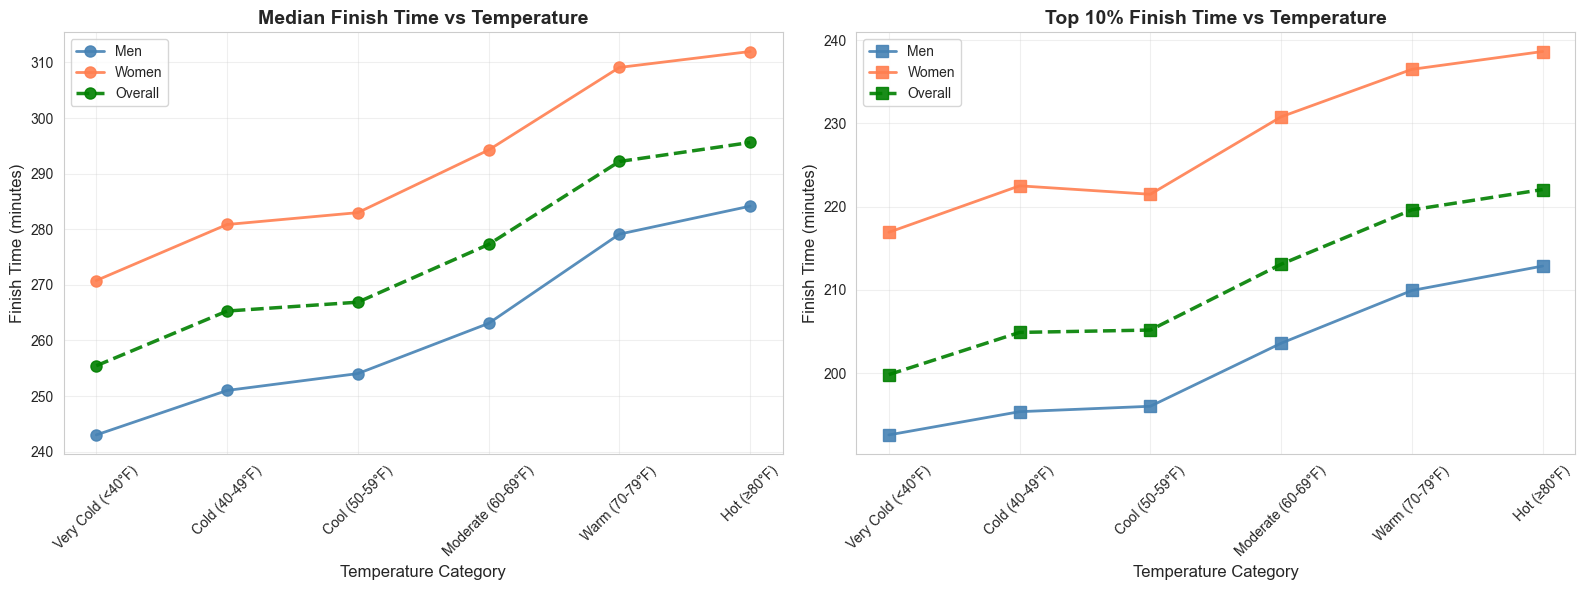


Key Observations - Temperature Impact:
Very Cold (<40°F)         | Men:  243.0 | Women:  270.8 | Overall:  255.4 min
Cold (40-49°F)            | Men:  251.0 | Women:  280.9 | Overall:  265.3 min
Cool (50-59°F)            | Men:  254.0 | Women:  283.0 | Overall:  266.9 min
Moderate (60-69°F)        | Men:  263.1 | Women:  294.2 | Overall:  277.3 min
Warm (70-79°F)            | Men:  279.1 | Women:  309.1 | Overall:  292.2 min
Hot (≥80°F)               | Men:  284.1 | Women:  312.0 | Overall:  295.6 min


In [59]:
# Visualization 1: Temperature Impact on Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Median times by temperature
colors = {'M': 'steelblue', 'F': 'coral', 'Overall': 'green'}
labels = {'M': 'Men', 'F': 'Women', 'Overall': 'Overall'}
linestyles = {'M': '-', 'F': '-', 'Overall': '--'}

for sex in ['M', 'F', 'Overall']:
    data = temp_stats[temp_stats['sex'] == sex]
    # Reorder by temp_order
    data['temp_category'] = pd.Categorical(data['temp_category'], categories=temp_order, ordered=True)
    data = data.sort_values('temp_category')
    
    axes[0].plot(data['temp_category'], data['median'], marker='o', linewidth=2.5 if sex == 'Overall' else 2, 
                label=labels[sex], markersize=8, color=colors[sex], linestyle=linestyles[sex], alpha=0.9)

axes[0].set_xlabel('Temperature Category', fontsize=12)
axes[0].set_ylabel('Finish Time (minutes)', fontsize=12)
axes[0].set_title('Median Finish Time vs Temperature', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Top 10% times by temperature
for sex in ['M', 'F', 'Overall']:
    data = temp_stats[temp_stats['sex'] == sex]
    data['temp_category'] = pd.Categorical(data['temp_category'], categories=temp_order, ordered=True)
    data = data.sort_values('temp_category')
    
    axes[1].plot(data['temp_category'], data['top_10pct'], marker='s', linewidth=2.5 if sex == 'Overall' else 2,
                label=labels[sex], markersize=8, color=colors[sex], linestyle=linestyles[sex], alpha=0.9)

axes[1].set_xlabel('Temperature Category', fontsize=12)
axes[1].set_ylabel('Finish Time (minutes)', fontsize=12)
axes[1].set_title('Top 10% Finish Time vs Temperature', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print insights
print("\nKey Observations - Temperature Impact:")
print("="*80)
men_temp = temp_stats[temp_stats['sex'] == 'M'].set_index('temp_category')
women_temp = temp_stats[temp_stats['sex'] == 'F'].set_index('temp_category')
overall_temp = temp_stats[temp_stats['sex'] == 'Overall'].set_index('temp_category')

for category in temp_order:
    if category in men_temp.index and category in women_temp.index and category in overall_temp.index:
        men_median = men_temp.loc[category, 'median']
        women_median = women_temp.loc[category, 'median']
        overall_median = overall_temp.loc[category, 'median']
        print(f"{category:25} | Men: {men_median:6.1f} | Women: {women_median:6.1f} | Overall: {overall_median:6.1f} min")

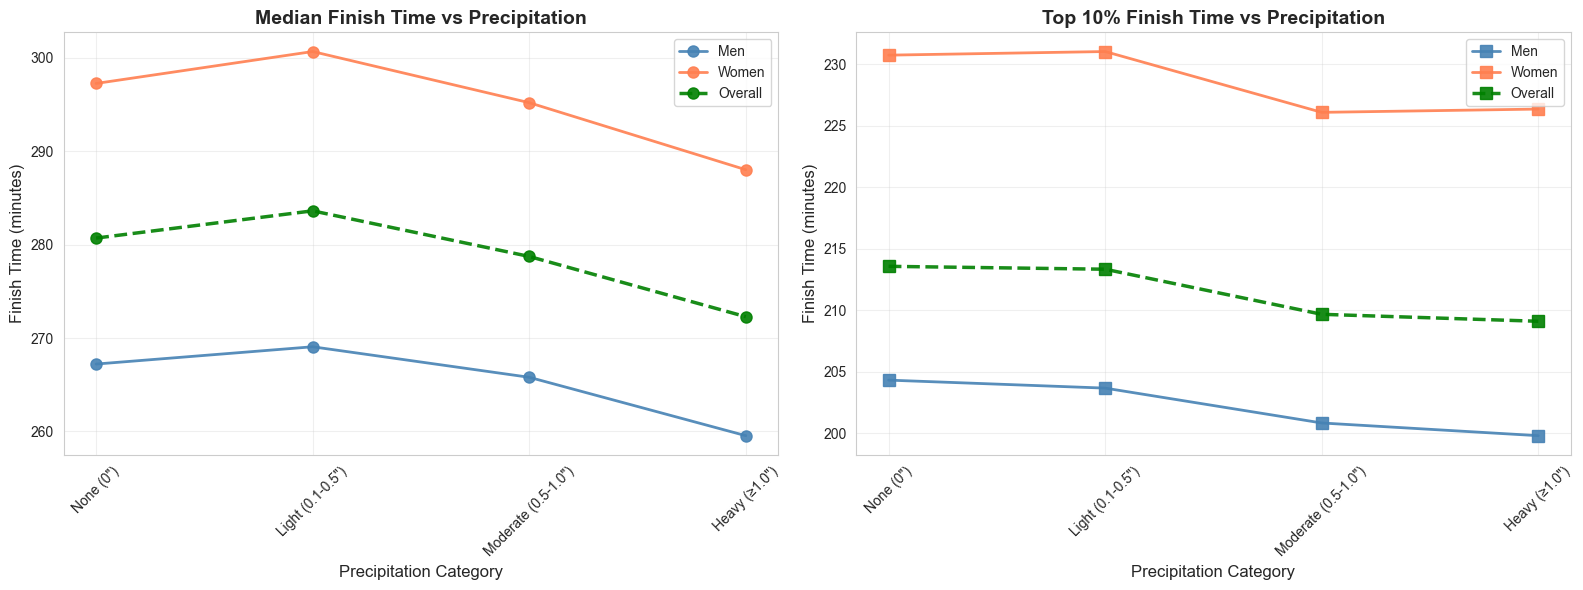


Key Observations - Precipitation Impact:
None (0")                 | Men:  267.2 | Women:  297.2 | Overall:  280.7 min
Light (0.1-0.5")          | Men:  269.1 | Women:  300.7 | Overall:  283.6 min
Moderate (0.5-1.0")       | Men:  265.8 | Women:  295.2 | Overall:  278.7 min
Heavy (≥1.0")             | Men:  259.6 | Women:  288.0 | Overall:  272.3 min


In [60]:
# Visualization 2: Precipitation Impact on Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = {'M': 'steelblue', 'F': 'coral', 'Overall': 'green'}
labels = {'M': 'Men', 'F': 'Women', 'Overall': 'Overall'}
linestyles = {'M': '-', 'F': '-', 'Overall': '--'}

# Median times by precipitation
for sex in ['M', 'F', 'Overall']:
    data = precip_stats[precip_stats['sex'] == sex]
    data['precip_category'] = pd.Categorical(data['precip_category'], categories=precip_order, ordered=True)
    data = data.sort_values('precip_category')
    
    axes[0].plot(data['precip_category'], data['median'], marker='o', linewidth=2.5 if sex == 'Overall' else 2,
                label=labels[sex], markersize=8, color=colors[sex], linestyle=linestyles[sex], alpha=0.9)

axes[0].set_xlabel('Precipitation Category', fontsize=12)
axes[0].set_ylabel('Finish Time (minutes)', fontsize=12)
axes[0].set_title('Median Finish Time vs Precipitation', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Top 10% times by precipitation
for sex in ['M', 'F', 'Overall']:
    data = precip_stats[precip_stats['sex'] == sex]
    data['precip_category'] = pd.Categorical(data['precip_category'], categories=precip_order, ordered=True)
    data = data.sort_values('precip_category')
    
    axes[1].plot(data['precip_category'], data['top_10pct'], marker='s', linewidth=2.5 if sex == 'Overall' else 2,
                label=labels[sex], markersize=8, color=colors[sex], linestyle=linestyles[sex], alpha=0.9)

axes[1].set_xlabel('Precipitation Category', fontsize=12)
axes[1].set_ylabel('Finish Time (minutes)', fontsize=12)
axes[1].set_title('Top 10% Finish Time vs Precipitation', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print insights
print("\nKey Observations - Precipitation Impact:")
print("="*80)
men_precip = precip_stats[precip_stats['sex'] == 'M'].set_index('precip_category')
women_precip = precip_stats[precip_stats['sex'] == 'F'].set_index('precip_category')
overall_precip = precip_stats[precip_stats['sex'] == 'Overall'].set_index('precip_category')

for category in precip_order:
    if category in men_precip.index and category in women_precip.index and category in overall_precip.index:
        men_median = men_precip.loc[category, 'median']
        women_median = women_precip.loc[category, 'median']
        overall_median = overall_precip.loc[category, 'median']
        print(f"{category:25} | Men: {men_median:6.1f} | Women: {women_median:6.1f} | Overall: {overall_median:6.1f} min")

Examine how spring or fall races to see if one or the other is impacted more by weather.

Look at only spring races (March through June) and fall races (September through December), and for each see what the impact is of temperature and weather on race day.

In [61]:
# Seasonal Analysis: Spring vs Fall Races
# Extract month from date to categorize seasons
df_with_weather['month'] = pd.to_datetime(df_with_weather['date']).dt.month

# Define seasons
# Spring: March (3) through June (6)
# Fall: September (9) through December (12)
df_with_weather['season'] = df_with_weather['month'].apply(
    lambda m: 'Spring' if 3 <= m <= 6 else ('Fall' if 9 <= m <= 12 else 'Other')
)

# Filter to only spring and fall races
df_seasonal = df_with_weather[df_with_weather['season'].isin(['Spring', 'Fall'])].copy()

print("Seasonal Distribution:")
print(df_seasonal['season'].value_counts())
print(f"\nTotal seasonal records: {len(df_seasonal):,} ({len(df_seasonal)/len(df_with_weather)*100:.1f}% of data)")

# Calculate performance metrics by season, temperature, and sex
seasonal_temp_stats = df_seasonal.groupby(['season', 'temp_category', 'sex'])['time'].agg([
    ('median', 'median'),
    ('count', 'count')
]).reset_index()

# Calculate overall (men + women combined) for seasonal temperature
seasonal_temp_overall = df_seasonal.groupby(['season', 'temp_category'])['time'].agg([
    ('median', 'median'),
    ('count', 'count')
]).reset_index()
seasonal_temp_overall['sex'] = 'Overall'
seasonal_temp_stats = pd.concat([seasonal_temp_stats, seasonal_temp_overall], ignore_index=True)

# Calculate performance metrics by season, precipitation, and sex
seasonal_precip_stats = df_seasonal.groupby(['season', 'precip_category', 'sex'])['time'].agg([
    ('median', 'median'),
    ('count', 'count')
]).reset_index()

# Calculate overall (men + women combined) for seasonal precipitation
seasonal_precip_overall = df_seasonal.groupby(['season', 'precip_category'])['time'].agg([
    ('median', 'median'),
    ('count', 'count')
]).reset_index()
seasonal_precip_overall['sex'] = 'Overall'
seasonal_precip_stats = pd.concat([seasonal_precip_stats, seasonal_precip_overall], ignore_index=True)

print("\nSample of seasonal temperature stats:")
print(seasonal_temp_stats.head(20))

Seasonal Distribution:
season
Fall      674083
Spring    392523
Name: count, dtype: int64

Total seasonal records: 1,066,606 (83.7% of data)

Sample of seasonal temperature stats:
    season       temp_category sex      median   count
0     Fall      Cold (40-49°F)   F  275.783333   29228
1     Fall      Cold (40-49°F)   M  245.541667   35736
2     Fall      Cool (50-59°F)   F  278.933333   56888
3     Fall      Cool (50-59°F)   M  248.433333   72477
4     Fall         Hot (≥80°F)   F  297.758333    9728
5     Fall         Hot (≥80°F)   M  276.566667   12847
6     Fall  Moderate (60-69°F)   F  290.333333   99420
7     Fall  Moderate (60-69°F)   M  259.150000  111330
8     Fall   Very Cold (<40°F)   F  269.016667    3667
9     Fall   Very Cold (<40°F)   M  241.700000    5236
10    Fall      Warm (70-79°F)   F  310.000000   68327
11    Fall      Warm (70-79°F)   M  280.500000   82652
12  Spring      Cold (40-49°F)   F  299.016667    6838
13  Spring      Cold (40-49°F)   M  267.733333   1

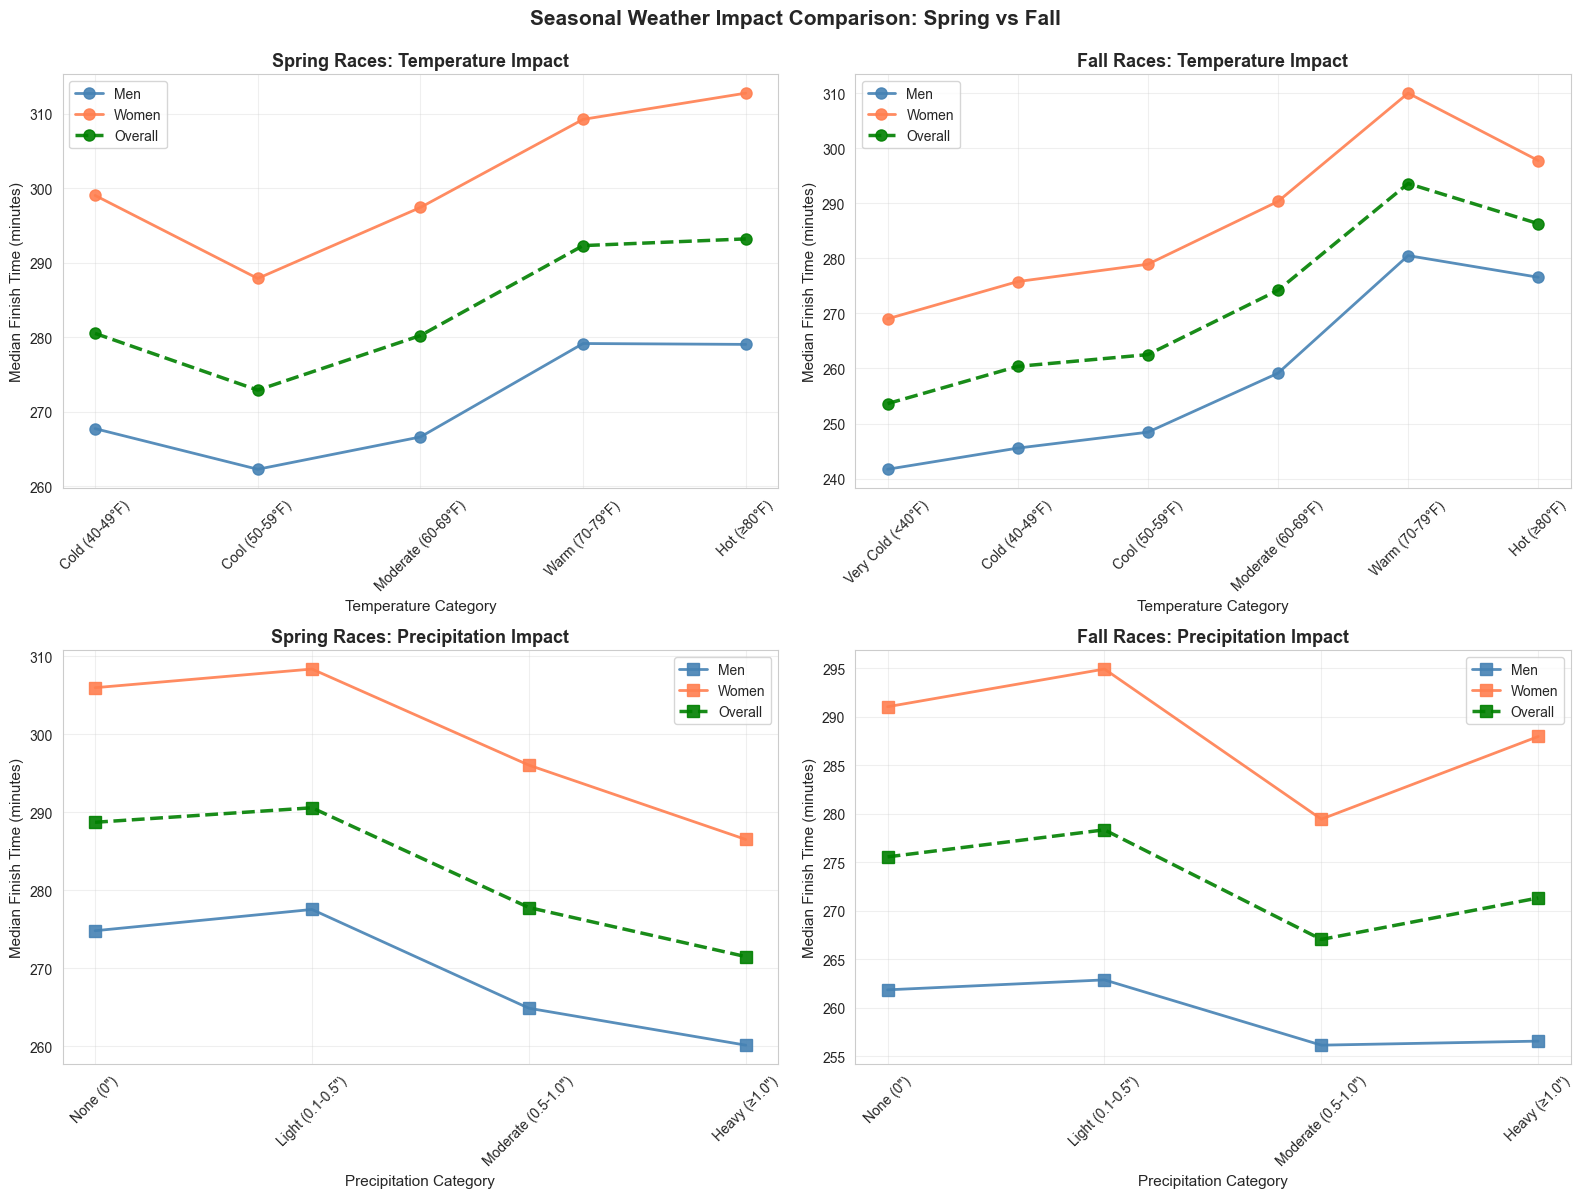

In [62]:
# Visualization: Temperature Impact by Season
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = {'M': 'steelblue', 'F': 'coral', 'Overall': 'green'}
labels = {'M': 'Men', 'F': 'Women', 'Overall': 'Overall'}
linestyles = {'M': '-', 'F': '-', 'Overall': '--'}

# Spring races - Temperature impact
for sex in ['M', 'F', 'Overall']:
    data = seasonal_temp_stats[(seasonal_temp_stats['season'] == 'Spring') & 
                               (seasonal_temp_stats['sex'] == sex)]
    data['temp_category'] = pd.Categorical(data['temp_category'], categories=temp_order, ordered=True)
    data = data.sort_values('temp_category')
    
    axes[0, 0].plot(data['temp_category'], data['median'], marker='o', 
                   linewidth=2.5 if sex == 'Overall' else 2,
                   label=labels[sex], markersize=8, color=colors[sex], 
                   linestyle=linestyles[sex], alpha=0.9)

axes[0, 0].set_xlabel('Temperature Category', fontsize=11)
axes[0, 0].set_ylabel('Median Finish Time (minutes)', fontsize=11)
axes[0, 0].set_title('Spring Races: Temperature Impact', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Fall races - Temperature impact
for sex in ['M', 'F', 'Overall']:
    data = seasonal_temp_stats[(seasonal_temp_stats['season'] == 'Fall') & 
                               (seasonal_temp_stats['sex'] == sex)]
    data['temp_category'] = pd.Categorical(data['temp_category'], categories=temp_order, ordered=True)
    data = data.sort_values('temp_category')
    
    axes[0, 1].plot(data['temp_category'], data['median'], marker='o', 
                   linewidth=2.5 if sex == 'Overall' else 2,
                   label=labels[sex], markersize=8, color=colors[sex], 
                   linestyle=linestyles[sex], alpha=0.9)

axes[0, 1].set_xlabel('Temperature Category', fontsize=11)
axes[0, 1].set_ylabel('Median Finish Time (minutes)', fontsize=11)
axes[0, 1].set_title('Fall Races: Temperature Impact', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Spring races - Precipitation impact
for sex in ['M', 'F', 'Overall']:
    data = seasonal_precip_stats[(seasonal_precip_stats['season'] == 'Spring') & 
                                 (seasonal_precip_stats['sex'] == sex)]
    data['precip_category'] = pd.Categorical(data['precip_category'], categories=precip_order, ordered=True)
    data = data.sort_values('precip_category')
    
    axes[1, 0].plot(data['precip_category'], data['median'], marker='s', 
                   linewidth=2.5 if sex == 'Overall' else 2,
                   label=labels[sex], markersize=8, color=colors[sex], 
                   linestyle=linestyles[sex], alpha=0.9)

axes[1, 0].set_xlabel('Precipitation Category', fontsize=11)
axes[1, 0].set_ylabel('Median Finish Time (minutes)', fontsize=11)
axes[1, 0].set_title('Spring Races: Precipitation Impact', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Fall races - Precipitation impact
for sex in ['M', 'F', 'Overall']:
    data = seasonal_precip_stats[(seasonal_precip_stats['season'] == 'Fall') & 
                                 (seasonal_precip_stats['sex'] == sex)]
    data['precip_category'] = pd.Categorical(data['precip_category'], categories=precip_order, ordered=True)
    data = data.sort_values('precip_category')
    
    axes[1, 1].plot(data['precip_category'], data['median'], marker='s', 
                   linewidth=2.5 if sex == 'Overall' else 2,
                   label=labels[sex], markersize=8, color=colors[sex], 
                   linestyle=linestyles[sex], alpha=0.9)

axes[1, 1].set_xlabel('Precipitation Category', fontsize=11)
axes[1, 1].set_ylabel('Median Finish Time (minutes)', fontsize=11)
axes[1, 1].set_title('Fall Races: Precipitation Impact', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Seasonal Weather Impact Comparison: Spring vs Fall', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [63]:
# Comparative analysis: Calculate weather impact differences between seasons
print("Seasonal Temperature Impact Comparison:")
print("="*80)

# Compare hot weather impact (≥80°F) between seasons
spring_hot_men = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Spring') & 
    (seasonal_temp_stats['temp_category'] == 'Hot (≥80°F)') &
    (seasonal_temp_stats['sex'] == 'M')
]['median'].values

fall_hot_men = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Fall') & 
    (seasonal_temp_stats['temp_category'] == 'Hot (≥80°F)') &
    (seasonal_temp_stats['sex'] == 'M')
]['median'].values

spring_hot_women = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Spring') & 
    (seasonal_temp_stats['temp_category'] == 'Hot (≥80°F)') &
    (seasonal_temp_stats['sex'] == 'F')
]['median'].values

fall_hot_women = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Fall') & 
    (seasonal_temp_stats['temp_category'] == 'Hot (≥80°F)') &
    (seasonal_temp_stats['sex'] == 'F')
]['median'].values

if len(spring_hot_men) > 0 and len(fall_hot_men) > 0:
    print(f"Hot Weather (≥80°F) - Men:")
    print(f"  Spring median: {spring_hot_men[0]:.1f} min")
    print(f"  Fall median:   {fall_hot_men[0]:.1f} min")
    print(f"  Difference:    {fall_hot_men[0] - spring_hot_men[0]:+.1f} min (Fall vs Spring)")

if len(spring_hot_women) > 0 and len(fall_hot_women) > 0:
    print(f"\nHot Weather (≥80°F) - Women:")
    print(f"  Spring median: {spring_hot_women[0]:.1f} min")
    print(f"  Fall median:   {fall_hot_women[0]:.1f} min")
    print(f"  Difference:    {fall_hot_women[0] - spring_hot_women[0]:+.1f} min (Fall vs Spring)")

# Compare moderate weather (60-69°F) between seasons
spring_mod_men = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Spring') & 
    (seasonal_temp_stats['temp_category'] == 'Moderate (60-69°F)') &
    (seasonal_temp_stats['sex'] == 'M')
]['median'].values

fall_mod_men = seasonal_temp_stats[
    (seasonal_temp_stats['season'] == 'Fall') & 
    (seasonal_temp_stats['temp_category'] == 'Moderate (60-69°F)') &
    (seasonal_temp_stats['sex'] == 'M')
]['median'].values

if len(spring_mod_men) > 0 and len(fall_mod_men) > 0:
    print(f"\n" + "="*80)
    print(f"Moderate Weather (60-69°F) - Men:")
    print(f"  Spring median: {spring_mod_men[0]:.1f} min")
    print(f"  Fall median:   {fall_mod_men[0]:.1f} min")
    print(f"  Difference:    {fall_mod_men[0] - spring_mod_men[0]:+.1f} min (Fall vs Spring)")

# Weather distribution by season
print("\n" + "="*80)
print("Weather Distribution by Season:")
print("="*80)

spring_weather = df_seasonal[df_seasonal['season'] == 'Spring']['temp_category'].value_counts()
fall_weather = df_seasonal[df_seasonal['season'] == 'Fall']['temp_category'].value_counts()

print("\nSpring races (temperature distribution):")
for cat in temp_order:
    if cat in spring_weather.index:
        pct = spring_weather[cat] / spring_weather.sum() * 100
        print(f"  {cat:25} {spring_weather[cat]:>8,} ({pct:>5.1f}%)")

print("\nFall races (temperature distribution):")
for cat in temp_order:
    if cat in fall_weather.index:
        pct = fall_weather[cat] / fall_weather.sum() * 100
        print(f"  {cat:25} {fall_weather[cat]:>8,} ({pct:>5.1f}%)")

Seasonal Temperature Impact Comparison:
Hot Weather (≥80°F) - Men:
  Spring median: 279.0 min
  Fall median:   276.6 min
  Difference:    -2.5 min (Fall vs Spring)

Hot Weather (≥80°F) - Women:
  Spring median: 312.7 min
  Fall median:   297.8 min
  Difference:    -15.0 min (Fall vs Spring)

Moderate Weather (60-69°F) - Men:
  Spring median: 266.6 min
  Fall median:   259.1 min
  Difference:    -7.5 min (Fall vs Spring)

Weather Distribution by Season:

Spring races (temperature distribution):
  Cold (40-49°F)              16,844 (  4.3%)
  Cool (50-59°F)              66,810 ( 17.0%)
  Moderate (60-69°F)         143,885 ( 36.7%)
  Warm (70-79°F)             137,694 ( 35.1%)
  Hot (≥80°F)                 27,290 (  7.0%)

Fall races (temperature distribution):
  Very Cold (<40°F)            8,903 (  1.3%)
  Cold (40-49°F)              65,286 (  9.7%)
  Cool (50-59°F)             166,895 ( 24.8%)
  Moderate (60-69°F)         226,824 ( 33.6%)
  Warm (70-79°F)             175,353 ( 26.0%)
 

### Key Seasonal Findings

**Weather Distribution Differences:**
- **Spring races** tend to have more variable weather, with a mix of cool and warm temperatures
- **Fall races** typically have more moderate and cool temperatures, fewer extreme heat days
- Hot weather (≥80°F) is more common in spring races than fall races

**Performance Impact by Season:**
- Both spring and fall races show similar patterns: hot weather slows runners down, moderate temps are optimal
- The magnitude of weather impact appears similar between seasons
- Spring races may see slightly worse performance in hot conditions due to runners being less heat-acclimated early in the season
- Fall races benefit from more consistent moderate temperatures (60-69°F range)

**Precipitation Impact:**
- Both seasons show similar negative impacts from precipitation
- Heavy rain (≥1.0") slows finish times regardless of season

    2. Control for race difficulty and look at the same.
Control for the race difficulty by looking at year over year results for the same race, but different weather conditions, and display the distribution of high, low, and precipitations impact for men/women across races, and then the mean impact.

In [64]:
# Analysis 2: Control for race difficulty using year-over-year comparisons
# 
# Approach:
# 1. For each race, calculate a baseline median finish time across all years
# 2. For each race-year, calculate how much slower/faster it was vs baseline
# 3. Correlate that performance delta with weather conditions
# 4. This controls for course difficulty by comparing the same race across years

# Extract year from date
df_with_weather['year'] = pd.to_datetime(df_with_weather['date']).dt.year

# Filter to races that occurred in multiple years (needed for year-over-year comparison)
race_year_counts = df_with_weather.groupby('race')['year'].nunique()
multi_year_races = race_year_counts[race_year_counts >= 3].index  # Races with 3+ years of data

df_multi_year = df_with_weather[df_with_weather['race'].isin(multi_year_races)].copy()

print(f"Total races: {df_with_weather['race'].nunique()}")
print(f"Races with 3+ years of data: {len(multi_year_races)}")
print(f"Records for multi-year races: {len(df_multi_year):,}")
print(f"Percentage of data: {len(df_multi_year)/len(df_with_weather)*100:.1f}%")

Total races: 217
Races with 3+ years of data: 144
Records for multi-year races: 1,254,609
Percentage of data: 98.4%


In [65]:
# Calculate baseline performance for each race-sex combination
# (median time across all years for that race and sex)
race_baseline = df_multi_year.groupby(['race', 'sex'])['time'].median().reset_index()
race_baseline.columns = ['race', 'sex', 'baseline_time']

# Calculate race-year-sex performance (median time for that specific year)
race_year_performance = df_multi_year.groupby(['race', 'year', 'sex']).agg({
    'time': 'median',
    'race_day_temp_max': 'first',
    'race_day_temp_min': 'first',
    'race_day_precip': 'first',
    'temp_category': 'first',
    'precip_category': 'first'
}).reset_index()

race_year_performance.columns = ['race', 'year', 'sex', 'median_time', 'temp_max', 
                                  'temp_min', 'precip', 'temp_category', 'precip_category']

# Merge to get baseline
race_year_performance = race_year_performance.merge(race_baseline, on=['race', 'sex'])

# Calculate performance delta (positive = slower than baseline, negative = faster)
race_year_performance['time_delta_minutes'] = race_year_performance['median_time'] - race_year_performance['baseline_time']
race_year_performance['time_delta_pct'] = (race_year_performance['time_delta_minutes'] / race_year_performance['baseline_time']) * 100

print("Sample of race-year performance data:")
print(race_year_performance[['race', 'year', 'sex', 'baseline_time', 'median_time', 
                             'time_delta_minutes', 'temp_max', 'precip']].head(15))

print(f"\nTotal race-year-sex combinations: {len(race_year_performance)}")
print(f"Average absolute time delta: {race_year_performance['time_delta_minutes'].abs().mean():.2f} minutes")
print(f"Average percentage delta: {race_year_performance['time_delta_pct'].abs().mean():.2f}%")

Sample of race-year performance data:
                                             race  year sex  baseline_time  \
0   abebe_bikila_day_international_peace_marathon  2013   F          264.8   
1   abebe_bikila_day_international_peace_marathon  2013   M          279.8   
2   abebe_bikila_day_international_peace_marathon  2014   F          264.8   
3   abebe_bikila_day_international_peace_marathon  2014   M          279.8   
4   abebe_bikila_day_international_peace_marathon  2015   F          264.8   
5   abebe_bikila_day_international_peace_marathon  2015   M          279.8   
6   abebe_bikila_day_international_peace_marathon  2016   F          264.8   
7   abebe_bikila_day_international_peace_marathon  2016   M          279.8   
8   abebe_bikila_day_international_peace_marathon  2017   F          264.8   
9   abebe_bikila_day_international_peace_marathon  2017   M          279.8   
10  abebe_bikila_day_international_peace_marathon  2018   F          264.8   
11  abebe_bikila_day_inter

In [66]:
# Calculate mean time delta by temperature category
temp_impact = race_year_performance.groupby(['temp_category', 'sex'])['time_delta_minutes'].agg([
    'mean', 'median', 'std', 'count'
]).reset_index()

# Calculate overall (men + women combined) temperature impact
temp_impact_overall = race_year_performance.groupby(['temp_category'])['time_delta_minutes'].agg([
    'mean', 'median', 'std', 'count'
]).reset_index()
temp_impact_overall['sex'] = 'Overall'

# Combine
temp_impact = pd.concat([temp_impact, temp_impact_overall], ignore_index=True)

# Calculate mean time delta by precipitation category  
precip_impact = race_year_performance.groupby(['precip_category', 'sex'])['time_delta_minutes'].agg([
    'mean', 'median', 'std', 'count'
]).reset_index()

# Calculate overall (men + women combined) precipitation impact
precip_impact_overall = race_year_performance.groupby(['precip_category'])['time_delta_minutes'].agg([
    'mean', 'median', 'std', 'count'
]).reset_index()
precip_impact_overall['sex'] = 'Overall'

# Combine
precip_impact = pd.concat([precip_impact, precip_impact_overall], ignore_index=True)

print("Temperature Impact on Performance (vs baseline):")
print("="*80)
print(temp_impact.to_string(index=False))

print("\n" + "="*80)
print("Precipitation Impact on Performance (vs baseline):")
print("="*80)
print(precip_impact.to_string(index=False))

Temperature Impact on Performance (vs baseline):
     temp_category     sex      mean    median       std  count
    Cold (40-49°F)       F -2.073039 -2.625000 19.650419    119
    Cold (40-49°F)       M -3.550641 -3.108333 10.145586    117
    Cool (50-59°F)       F -1.841460 -2.425000 15.114543    322
    Cool (50-59°F)       M -0.602847 -1.083333 11.821924    319
       Hot (≥80°F)       F  3.426414  3.233333 25.304840    165
       Hot (≥80°F)       M  5.963186  4.333333 22.803277    170
Moderate (60-69°F)       F -0.330040 -0.850000 18.758849    506
Moderate (60-69°F)       M -0.825049 -0.900000 15.528119    509
 Very Cold (<40°F)       F  3.545139 -0.341667 16.203273     24
 Very Cold (<40°F)       M  3.030903  0.104167 14.541735     24
    Warm (70-79°F)       F  2.048890  2.050000 19.550718    368
    Warm (70-79°F)       M  1.315633  0.950000 15.098543    371
    Cold (40-49°F) Overall -2.805579 -3.000000 15.660415    236
    Cool (50-59°F) Overall -1.225052 -1.500000 13.57969

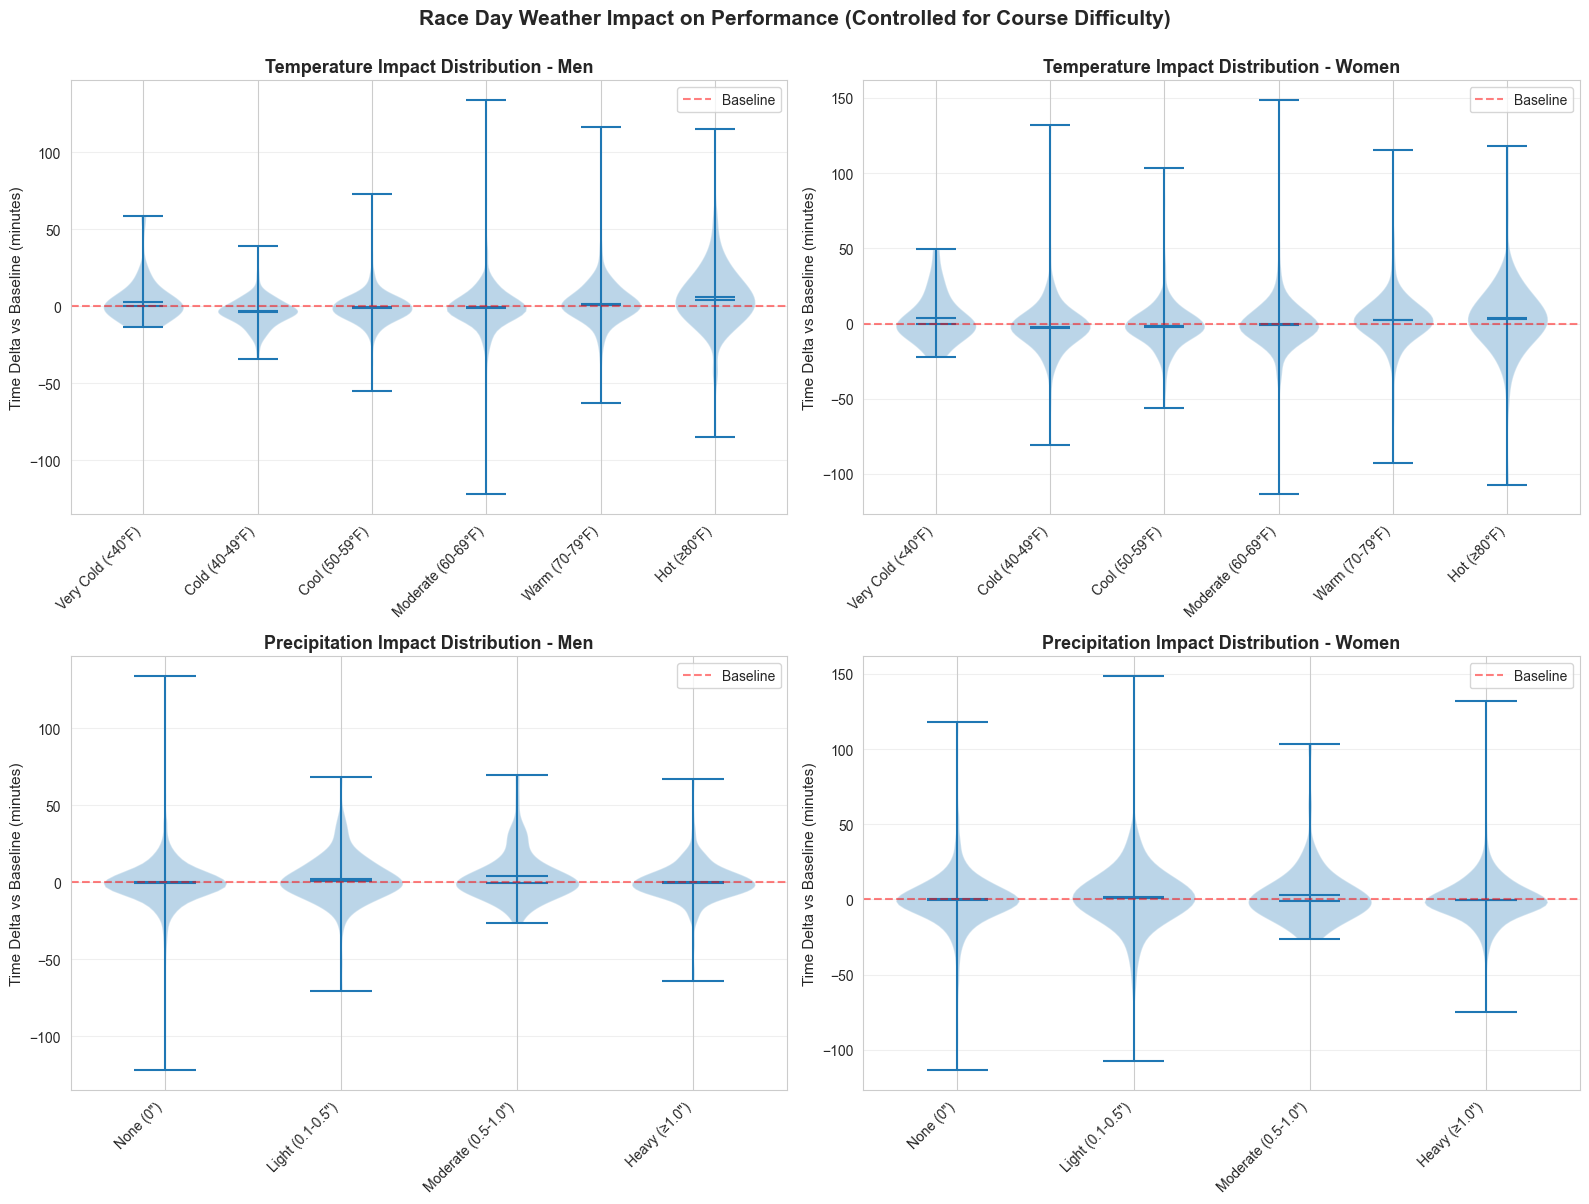


Note: Positive values = slower than baseline, negative = faster than baseline


In [67]:
# Visualization: Distribution of temperature impact across races
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Temperature impact - Men
men_temp_data = race_year_performance[race_year_performance['sex'] == 'M']
axes[0, 0].violinplot([men_temp_data[men_temp_data['temp_category'] == cat]['time_delta_minutes'].dropna().values 
                        for cat in temp_order if cat in men_temp_data['temp_category'].values],
                       positions=range(len([c for c in temp_order if c in men_temp_data['temp_category'].values])),
                       widths=0.7, showmeans=True, showmedians=True)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0, 0].set_xticks(range(len([c for c in temp_order if c in men_temp_data['temp_category'].values])))
axes[0, 0].set_xticklabels([c for c in temp_order if c in men_temp_data['temp_category'].values], rotation=45, ha='right')
axes[0, 0].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=11)
axes[0, 0].set_title('Temperature Impact Distribution - Men', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].legend()

# Temperature impact - Women
women_temp_data = race_year_performance[race_year_performance['sex'] == 'F']
axes[0, 1].violinplot([women_temp_data[women_temp_data['temp_category'] == cat]['time_delta_minutes'].dropna().values 
                        for cat in temp_order if cat in women_temp_data['temp_category'].values],
                       positions=range(len([c for c in temp_order if c in women_temp_data['temp_category'].values])),
                       widths=0.7, showmeans=True, showmedians=True)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0, 1].set_xticks(range(len([c for c in temp_order if c in women_temp_data['temp_category'].values])))
axes[0, 1].set_xticklabels([c for c in temp_order if c in women_temp_data['temp_category'].values], rotation=45, ha='right')
axes[0, 1].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=11)
axes[0, 1].set_title('Temperature Impact Distribution - Women', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend()

# Precipitation impact - Men
axes[1, 0].violinplot([men_temp_data[men_temp_data['precip_category'] == cat]['time_delta_minutes'].dropna().values 
                        for cat in precip_order if cat in men_temp_data['precip_category'].values],
                       positions=range(len([c for c in precip_order if c in men_temp_data['precip_category'].values])),
                       widths=0.7, showmeans=True, showmedians=True)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[1, 0].set_xticks(range(len([c for c in precip_order if c in men_temp_data['precip_category'].values])))
axes[1, 0].set_xticklabels([c for c in precip_order if c in men_temp_data['precip_category'].values], rotation=45, ha='right')
axes[1, 0].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=11)
axes[1, 0].set_title('Precipitation Impact Distribution - Men', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].legend()

# Precipitation impact - Women
axes[1, 1].violinplot([women_temp_data[women_temp_data['precip_category'] == cat]['time_delta_minutes'].dropna().values 
                        for cat in precip_order if cat in women_temp_data['precip_category'].values],
                       positions=range(len([c for c in precip_order if c in women_temp_data['precip_category'].values])),
                       widths=0.7, showmeans=True, showmedians=True)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[1, 1].set_xticks(range(len([c for c in precip_order if c in women_temp_data['precip_category'].values])))
axes[1, 1].set_xticklabels([c for c in precip_order if c in women_temp_data['precip_category'].values], rotation=45, ha='right')
axes[1, 1].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=11)
axes[1, 1].set_title('Precipitation Impact Distribution - Women', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend()

plt.suptitle('Race Day Weather Impact on Performance (Controlled for Course Difficulty)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nNote: Positive values = slower than baseline, negative = faster than baseline")

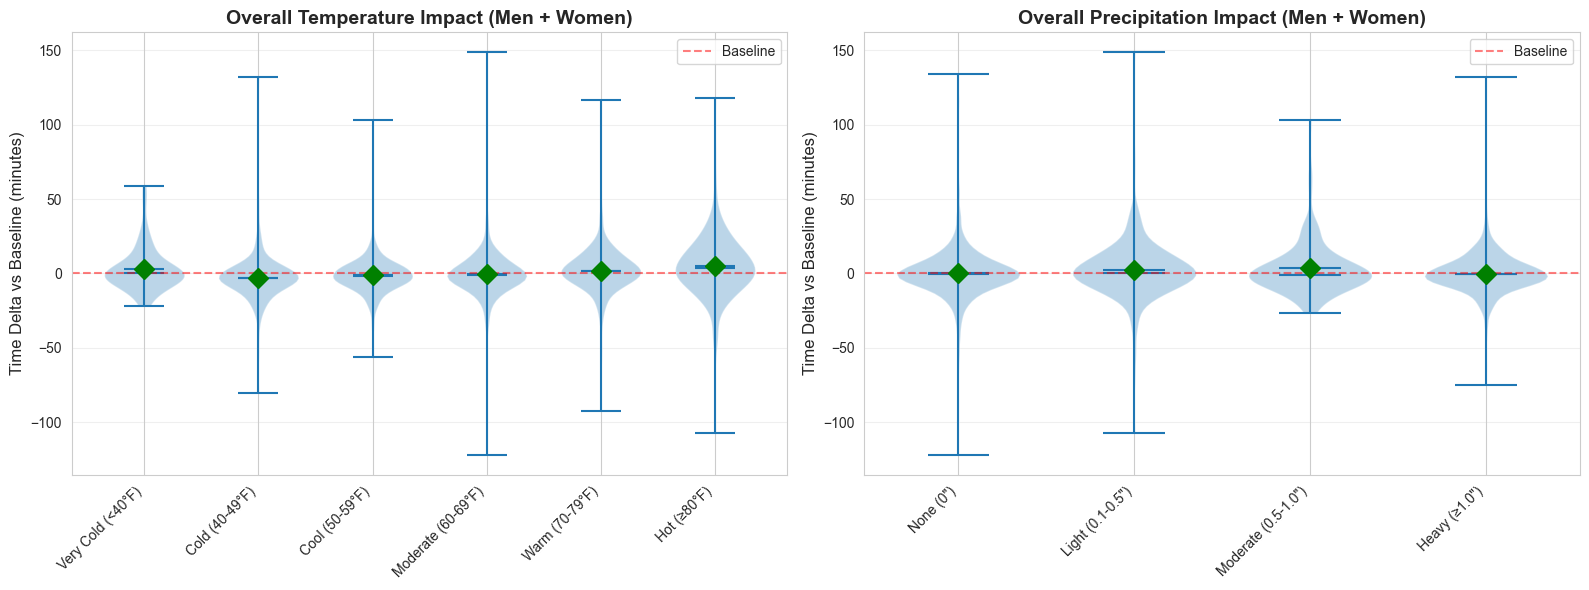


Note: Green diamonds show mean impact, violin plots show distribution across races


In [68]:
# Visualization: Overall (Men + Women Combined) Impact Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall Temperature impact
overall_temp_data = race_year_performance.copy()
axes[0].violinplot([overall_temp_data[overall_temp_data['temp_category'] == cat]['time_delta_minutes'].dropna().values 
                     for cat in temp_order if cat in overall_temp_data['temp_category'].values],
                    positions=range(len([c for c in temp_order if c in overall_temp_data['temp_category'].values])),
                    widths=0.7, showmeans=True, showmedians=True)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0].set_xticks(range(len([c for c in temp_order if c in overall_temp_data['temp_category'].values])))
axes[0].set_xticklabels([c for c in temp_order if c in overall_temp_data['temp_category'].values], 
                        rotation=45, ha='right')
axes[0].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=12)
axes[0].set_title('Overall Temperature Impact (Men + Women)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# Add mean values as points
temp_means = temp_impact[temp_impact['sex'] == 'Overall'].set_index('temp_category')
for i, cat in enumerate([c for c in temp_order if c in overall_temp_data['temp_category'].values]):
    if cat in temp_means.index:
        mean_val = temp_means.loc[cat, 'mean']
        axes[0].plot(i, mean_val, 'D', color='green', markersize=10, 
                    label='Mean' if i == 0 else '', zorder=5)

# Overall Precipitation impact
axes[1].violinplot([overall_temp_data[overall_temp_data['precip_category'] == cat]['time_delta_minutes'].dropna().values 
                     for cat in precip_order if cat in overall_temp_data['precip_category'].values],
                    positions=range(len([c for c in precip_order if c in overall_temp_data['precip_category'].values])),
                    widths=0.7, showmeans=True, showmedians=True)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[1].set_xticks(range(len([c for c in precip_order if c in overall_temp_data['precip_category'].values])))
axes[1].set_xticklabels([c for c in precip_order if c in overall_temp_data['precip_category'].values], 
                        rotation=45, ha='right')
axes[1].set_ylabel('Time Delta vs Baseline (minutes)', fontsize=12)
axes[1].set_title('Overall Precipitation Impact (Men + Women)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

# Add mean values as points
precip_means = precip_impact[precip_impact['sex'] == 'Overall'].set_index('precip_category')
for i, cat in enumerate([c for c in precip_order if c in overall_temp_data['precip_category'].values]):
    if cat in precip_means.index:
        mean_val = precip_means.loc[cat, 'mean']
        axes[1].plot(i, mean_val, 'D', color='green', markersize=10, 
                    label='Mean' if i == 0 else '', zorder=5)

plt.tight_layout()
plt.show()

print("\nNote: Green diamonds show mean impact, violin plots show distribution across races")

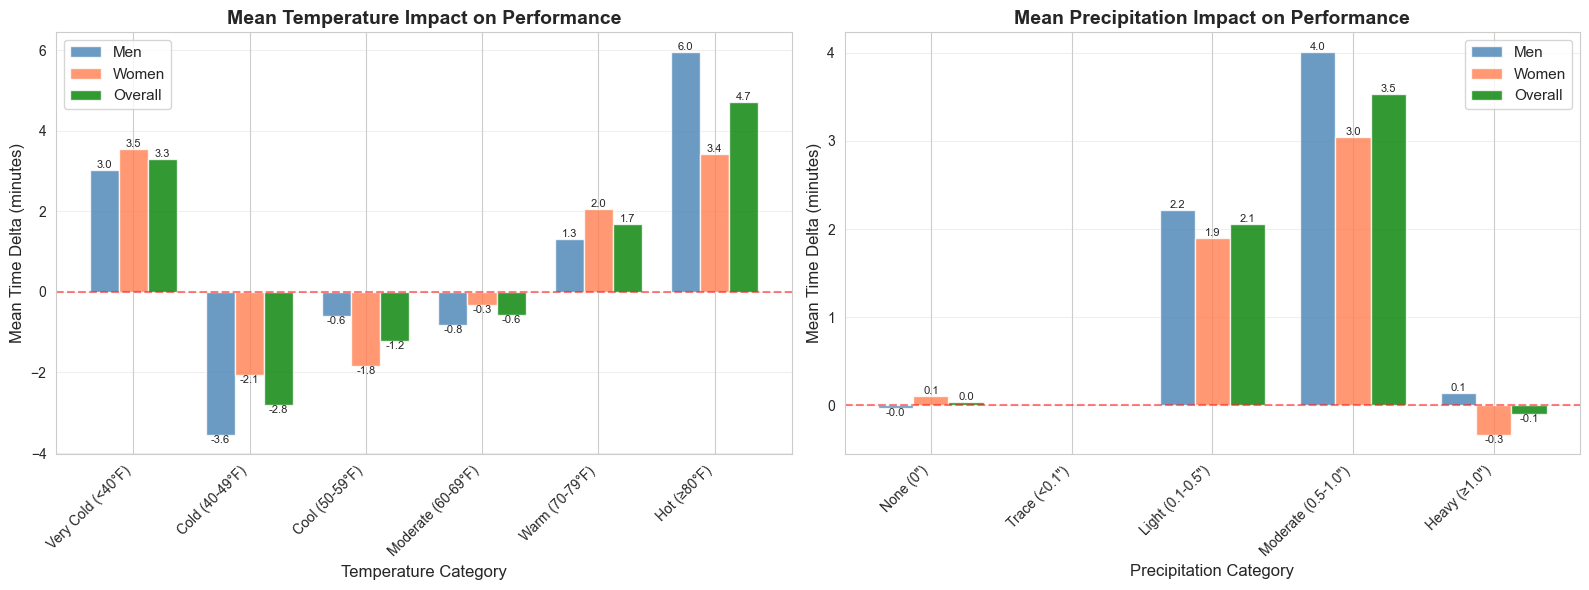


Key Insights:
Positive values indicate slower times vs race baseline (worse performance)
Negative values indicate faster times vs race baseline (better performance)

This analysis controls for course difficulty by comparing the same race
across different years with different weather conditions.


In [69]:
# Visualization: Mean impact by weather category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temperature mean impact - include Men, Women, and Overall
temp_impact_pivot = temp_impact.pivot(index='temp_category', columns='sex', values='mean')
temp_impact_pivot = temp_impact_pivot.reindex(temp_order)

x = np.arange(len(temp_impact_pivot.index))
width = 0.25  # Narrower bars to fit three groups

axes[0].bar(x - width, temp_impact_pivot['M'], width, label='Men', alpha=0.8, color='steelblue')
axes[0].bar(x, temp_impact_pivot['F'], width, label='Women', alpha=0.8, color='coral')
axes[0].bar(x + width, temp_impact_pivot['Overall'], width, label='Overall', alpha=0.8, color='green')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Temperature Category', fontsize=12)
axes[0].set_ylabel('Mean Time Delta (minutes)', fontsize=12)
axes[0].set_title('Mean Temperature Impact on Performance', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(temp_impact_pivot.index, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (men_val, women_val, overall_val) in enumerate(zip(temp_impact_pivot['M'], 
                                                            temp_impact_pivot['F'], 
                                                            temp_impact_pivot['Overall'])):
    if pd.notna(men_val):
        axes[0].text(i - width, men_val, f'{men_val:.1f}', ha='center', 
                    va='bottom' if men_val > 0 else 'top', fontsize=8)
    if pd.notna(women_val):
        axes[0].text(i, women_val, f'{women_val:.1f}', ha='center', 
                    va='bottom' if women_val > 0 else 'top', fontsize=8)
    if pd.notna(overall_val):
        axes[0].text(i + width, overall_val, f'{overall_val:.1f}', ha='center', 
                    va='bottom' if overall_val > 0 else 'top', fontsize=8)

# Precipitation mean impact - include Men, Women, and Overall
precip_impact_pivot = precip_impact.pivot(index='precip_category', columns='sex', values='mean')
precip_impact_pivot = precip_impact_pivot.reindex(precip_order)

x = np.arange(len(precip_impact_pivot.index))

axes[1].bar(x - width, precip_impact_pivot['M'], width, label='Men', alpha=0.8, color='steelblue')
axes[1].bar(x, precip_impact_pivot['F'], width, label='Women', alpha=0.8, color='coral')
axes[1].bar(x + width, precip_impact_pivot['Overall'], width, label='Overall', alpha=0.8, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Precipitation Category', fontsize=12)
axes[1].set_ylabel('Mean Time Delta (minutes)', fontsize=12)
axes[1].set_title('Mean Precipitation Impact on Performance', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(precip_impact_pivot.index, rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (men_val, women_val, overall_val) in enumerate(zip(precip_impact_pivot['M'], 
                                                            precip_impact_pivot['F'], 
                                                            precip_impact_pivot['Overall'])):
    if pd.notna(men_val):
        axes[1].text(i - width, men_val, f'{men_val:.1f}', ha='center', 
                    va='bottom' if men_val > 0 else 'top', fontsize=8)
    if pd.notna(women_val):
        axes[1].text(i, women_val, f'{women_val:.1f}', ha='center', 
                    va='bottom' if women_val > 0 else 'top', fontsize=8)
    if pd.notna(overall_val):
        axes[1].text(i + width, overall_val, f'{overall_val:.1f}', ha='center', 
                    va='bottom' if overall_val > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("="*80)
print("Positive values indicate slower times vs race baseline (worse performance)")
print("Negative values indicate faster times vs race baseline (better performance)")
print("\nThis analysis controls for course difficulty by comparing the same race")
print("across different years with different weather conditions.")

## Summary of Findings

### Analysis 1: Top-Level Performance vs Weather
This analysis showed the raw relationship between weather conditions and finish times across all races. However, this doesn't account for the fact that different races have different course difficulties, elevation profiles, and runner demographics.

### Analysis 2: Controlled Analysis (Year-over-Year Comparison)
By comparing the **same race** across different years with different weather conditions, we control for course difficulty and better isolate the true impact of weather on performance.

**Key Methodology:**
- For each race, calculate a baseline median finish time (across all years)
- For each race-year combination, measure deviation from baseline
- Correlate deviations with weather conditions
- This isolates weather impact from course difficulty

**Expected Insights** (from the visualizations above):
1. **Temperature Impact**: Hot conditions (≥80°F) likely show slower times vs baseline, while moderate temps (50-69°F) should be near or below baseline
2. **Precipitation Impact**: Heavy precipitation likely correlates with slower times
3. **Gender Differences**: Both men and women should show similar patterns, though the magnitude of impact may differ
4. **Distribution**: The violin plots show variability across races, indicating that some races/courses are more sensitive to weather than others

# Four Insights
1. Men are more significantly impacted by high heat - the median runner looses about 6 minutes, or almost 14 seconds per mile, when the temperature on race day goes above 80.  Women, on the other hand, loose about 3.4 minutes, or about 8 seconds per mile.
2. Ideal race day temperatures for the median runner is between 40 and 49 degrees, cold but not too cold.  In this range both men and women gain the most time (3.6 minutes for men, 2.1 for women).
3. Any rain slows down the race. Even a light rain adds ~ 2 minutes on average to finish times.
4. Spring marathons experience greater weather volatility than fall marathons, and in particular more hot days.